In [38]:
import pandas as pd
from urllib.request import Request, urlopen
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import time
import sys
import re
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import math
import tensorflow as tf
pd.set_option('display.max_rows', None)

In [39]:
#from google.colab import drive 
#drive.mount('/content/gdrive')

In [51]:
df=pd.read_csv('../processed_data/price_df_10mins_furtherpreprocess_24hvol.csv')
df['tx_timestamp'] = pd.to_datetime(df['tx_timestamp'],unit='ns')
df = df.rename(columns = {"tx_timestamp":"timestamp","0":"volatility"})
display(df.head(3))
df.tail()
df = df.set_index('timestamp')
vol_df =df[['24rolling_vol']]*np.sqrt(365)
ret_df = df[['ret']].fillna(0)

,Unnamed: 0,timestamp,first,last,mean,vol_of_vol,max,min,ret,24rolling_vol
0,0,2020-05-26 21:00:00+00:00,201.177211,201.177211,201.0,NaN,201.177211,201.177211,0.0,NaN
1,1,2020-05-26 21:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-05-26 21:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
vol_df = vol_df.fillna(method ='ffill')
vol_df = vol_df.fillna(0)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127690 entries, 2020-05-26 21:00:00+00:00 to 2022-10-30 14:30:00+00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     127690 non-null  int64  
 1   first          123940 non-null  float64
 2   last           123940 non-null  float64
 3   mean           123940 non-null  float64
 4   vol_of_vol     122505 non-null  float64
 5   max            123940 non-null  float64
 6   min            123940 non-null  float64
 7   ret            123940 non-null  float64
 8   24rolling_vol  112911 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 9.7 MB


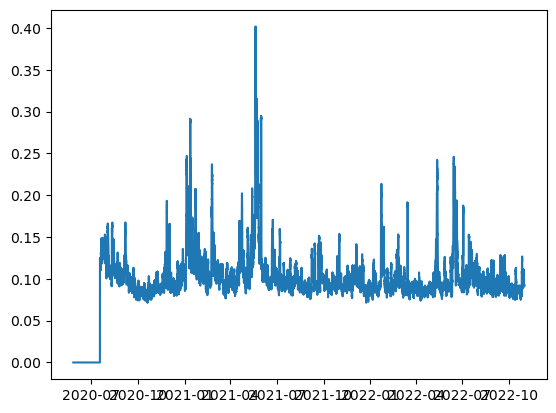

In [43]:
plt.plot(df.index,vol_df)

In [44]:
df.shape

(127690, 9)

In [45]:
train_start = '2020-05-26'
train_end = '2022-07-31'
dev_start = '2022-08-01'
dev_end = '2022-09-30'
test_start = '2022-10-01'
test_end = '2022-10-31'

In [46]:
df= vol_df

In [47]:
vol_df.head()

,24rolling_vol
timestamp,
2020-05-26 21:00:00+00:00,0.0
2020-05-26 21:10:00+00:00,0.0
2020-05-26 21:20:00+00:00,0.0
2020-05-26 21:30:00+00:00,0.0
2020-05-26 21:40:00+00:00,0.0


In [48]:
train_dates = df[((df.index >= train_start) & (df.index <= train_end))]['24rolling_vol'].values.reshape((-1,1))
dev_dates = df[((df.index >= dev_start) & (df.index <= dev_end))]['24rolling_vol'].values.reshape((-1,1))
test_dates = df[((df.index >= test_start) & (df.index <= test_end))]['24rolling_vol'].values.reshape((-1,1))
train_dates.shape, dev_dates.shape, test_dates.shape

((114499, 1), (8641, 1), (4264, 1))

## Additional Baseline: Exponential moving vol

In [49]:
days_look_back = 2
n_input = 24*6*days_look_back

In [99]:
train_naive_base =vol_df.fillna(0)[((vol_df.index >= train_start) & (vol_df.index <= train_end))].ewm(halflife = n_input).mean()
train_naive_prediction = train_naive_base.shift(1)

In [100]:
dev_naive_base = vol_df.fillna(0)[((vol_df.index >= dev_start) & (vol_df.index <= dev_end))].ewm(halflife = n_input).mean()
dev_naive_prediction = dev_naive_base.shift(1)

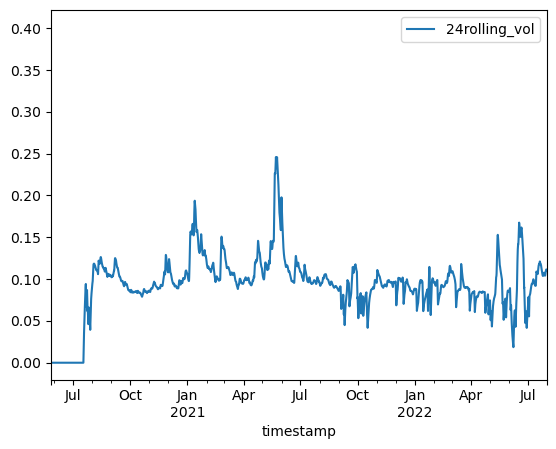

In [107]:
train_naive_prediction.plot()


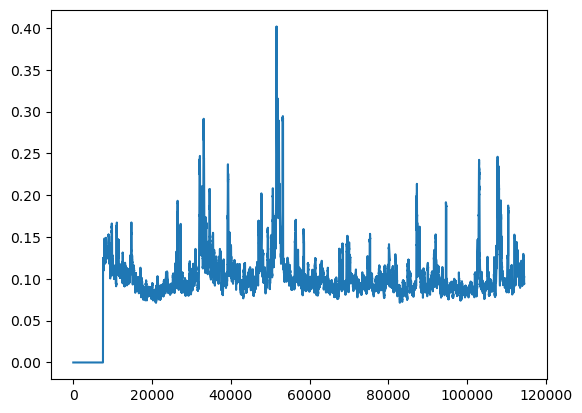

In [108]:
plt.plot(train_dates)

<AxesSubplot: xlabel='timestamp'>

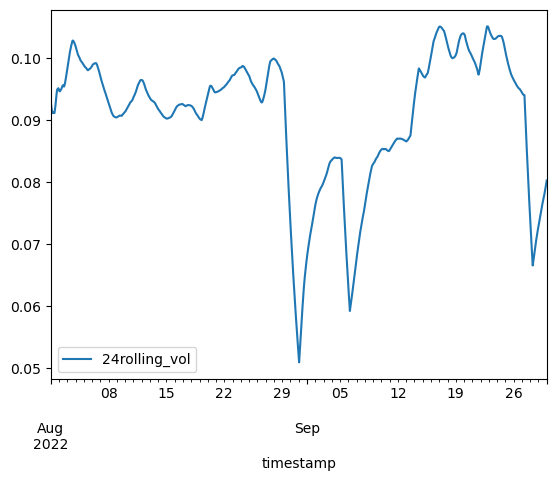

In [103]:
dev_naive_prediction.plot()

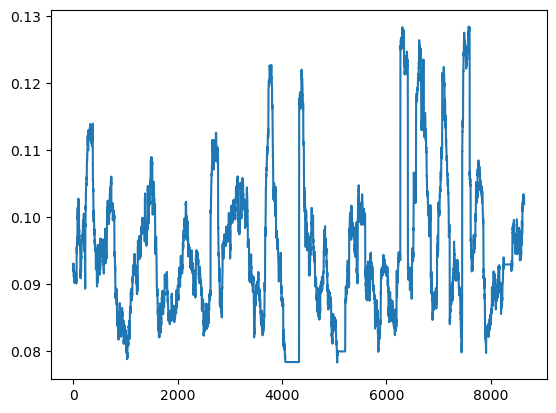

In [106]:
plt.plot(dev_dates)

In [113]:
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(dev_naive_prediction[1:], dev_dates[1:]))
print(mean_absolute_percentage_error(train_naive_prediction[1:], train_dates[1:]))

0.12418507549692633
4786041497.460101


In [115]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(dev_naive_prediction[1:], dev_dates[1:]))
print(mean_squared_error(train_naive_prediction[1:], train_dates[1:]))

0.00019880873991201753
0.0006039966529301712


### Modelling

In [34]:
from keras.preprocessing.sequence import TimeseriesGenerator
days_look_back = 2
n_input = 24*6*days_look_back
n_features = 1
train_data_gen = TimeseriesGenerator(train_dates, train_dates ,length=n_input, batch_size=1)
dev_data_gen = TimeseriesGenerator(dev_dates, dev_dates,length=n_input, batch_size=1)

In [35]:
train_data_gen

In [37]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor = 'loss', patience=2, min_delta=1e-4)

model = Sequential()
model.add(LSTM(64,activation='relu',input_shape=(n_input,n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsolutePercentageError())

num_epochs = 25

history = model.fit(train_data_gen , epochs=num_epochs)

Epoch 1/25


2022-12-02 05:54:11.600695: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-12-02 05:54:11.600762: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2022-12-02 05:54:11.600788: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:442 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support
2022-12-02 05:54:11.604253: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2022-12-02 05:54:11.604284: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory

InternalError: Graph execution error:

Detected at node 'sequential_5/lstm_4/while/lstm_cell_4/MatMul_1' defined at (most recent call last):
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/traitlets/config/application.py", line 982, in launch_instance
      app.start()
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_41841/3757729333.py", line 15, in <module>
      history = model.fit(train_data_gen , epochs=num_epochs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/layers/recurrent.py", line 679, in __call__
      return super(RNN, self).__call__(inputs, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/layers/recurrent_v2.py", line 1159, in call
      last_output, outputs, states = backend.rnn(
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/backend.py", line 4743, in rnn
      final_outputs = tf.compat.v1.while_loop(
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/backend.py", line 4729, in _step
      output, new_states = step_function(current_input,
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/layers/recurrent_v2.py", line 1157, in step
      return self.cell(inputs, states, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/layers/recurrent.py", line 2499, in call
      z += backend.dot(h_tm1, self.recurrent_kernel)
    File "/home/ubuntu/miniconda3/envs/crypto_vol_prediction/lib/python3.8/site-packages/keras/backend.py", line 2223, in dot
      out = tf.matmul(x, y)
Node: 'sequential_5/lstm_4/while/lstm_cell_4/MatMul_1'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node sequential_5/lstm_4/while/lstm_cell_4/MatMul_1}}]] [Op:__inference_train_function_2816]

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_save_name = 'lstm64_dense_ep25_baseline_mape'
model.save('model_{}.h5'.format(model_save_name))

In [ ]:
#import tensorflow as tf
#from tensorflow import keras
#new_model = tf.keras.models.load_model('/content/gdrive/My Drive/cs230models/model_{}.h5'.format(model_save_name))

# Check its architecture
#new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model.evaluate_generator(dev_data_gen)
#trainPredict = model.predict_generator(train_data_gen)
#devPredict = model.predict_generator(dev_data_gen)

In [23]:
X_dev, y_dev = split_sequence(dev_dates, n_steps)
X_dev = X_dev.reshape((X_dev.shape[0], n_steps, n_features))
y_dev_pred = model.predict(X_dev)
y_train_pred = model.predict(X.reshape((X.shape[0], n_steps, n_features)))
print(y_dev_pred.shape, y_train_pred.shape)
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(y_dev_pred, dev_dates[24*6*days_look_back:]))
print(mean_absolute_percentage_error(y_train_pred, train_dates[24*6*days_look_back:]))

(8353, 1) (114211, 1)
36.764655342213
43.58805823438085


In [25]:
##train stacked LSTM overnight

In [26]:
# define input sequence
raw_seq = train_dates
# choose a number of time steps
days_look_back = 7
n_steps = 24*6*days_look_back
# split into samples
X, y = split_sequence(raw_seq, n_steps)

n_features = 1

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

#early_stopping = EarlyStopping(monitor = 'loss', patience=2, min_delta=1e-4)

model1 = Sequential()
model1.add(LSTM(64,activation='relu',return_sequences=True, input_shape=(n_steps,n_features)))
model1.add(LSTM(32, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss=tf.keras.losses.MeanAbsolutePercentageError())

num_epochs = 25

X = X.reshape((X.shape[0], X.shape[1], n_features))
history = model1.fit(X, y, epochs=num_epochs)

Epoch 1/25
3547/3547 [==============================] - 8857s 2s/step - loss: 14826.4521
Epoch 2/25
3547/3547 [==============================] - 8849s 2s/step - loss: 13591.6650
Epoch 3/25
3547/3547 [==============================] - 8861s 2s/step - loss: 12614.7012
Epoch 4/25
3547/3547 [==============================] - 8862s 2s/step - loss: 14298.3945
Epoch 5/25
3547/3547 [==============================] - 8862s 2s/step - loss: 12116.7949
Epoch 6/25
3547/3547 [==============================] - 8890s 3s/step - loss: 12877.0283
Epoch 7/25
3547/3547 [==============================] - 8877s 3s/step - loss: 13842.5488
Epoch 8/25
3547/3547 [==============================] - 8879s 3s/step - loss: 13127.1533
Epoch 9/25
1464/3547 [===========>..................] - ETA: 1:26:51 - loss: 11806.8799

In [ ]:
model1.summary()

In [ ]:
model_save_name = 'lstm6432_dense_ep25_back7_mape'
model1.save('model_{}.h5'.format(model_save_name))

In [ ]:
X_dev, y_dev = split_sequence(dev_dates, n_steps)
X_dev = X_dev.reshape((X_dev.shape[0], n_steps, n_features))
y_dev_pred = model1.predict(X_dev)
y_train_pred = model1.predict(X.reshape((X.shape[0], n_steps, n_features)))
print(y_dev_pred.shape, y_train_pred.shape)
from sklearn.metrics import mean_absolute_percentage_error
print(mean_absolute_percentage_error(y_dev_pred, dev_dates[24*6*days_look_back:]))
print(mean_absolute_percentage_error(y_train_pred, train_dates[24*6*days_look_back:]))